In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('..')

import dataset
import numbs
import tree_search
import backprop
import lpbackprop
import jump_backprop
import constraints

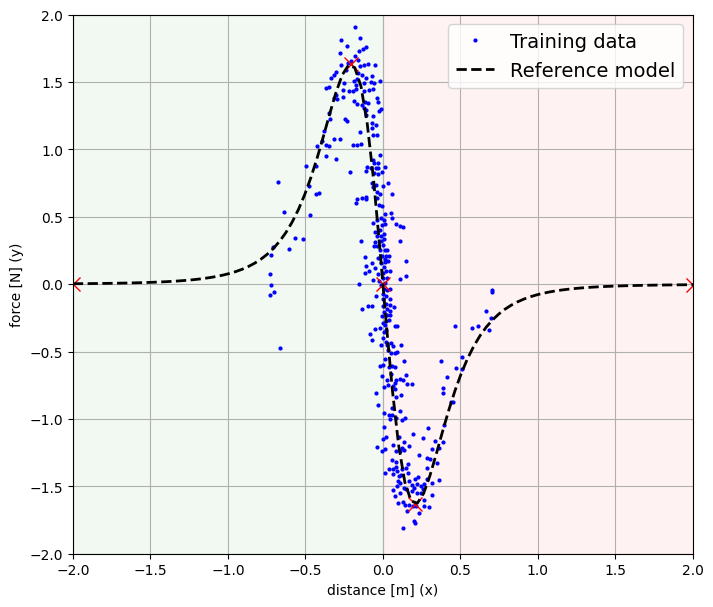

In [2]:
S = dataset.MagmanDatasetScaled()
#S.sample(size=150, noise=0.05, mesh=False)
S.load('../data/magman.csv')
S.plot(width=8, height=7)

"""new_data = []
for dp in S.data:
    if dp.x < 0 and dp.y > 0 or \
       dp.x > 0 and dp.y < 0: new_data.append(dp)
S.data = new_data"""

S.index()
numbs.init(S)

In [3]:
unknown_stree_a = backprop.UnknownSyntaxTree('A')
unknown_stree_b = backprop.UnknownSyntaxTree('B')
stree     = backprop.BinaryOperatorSyntaxTree('/', unknown_stree_a, unknown_stree_b)
stree_pr  = stree.diff().simplify()
stree_pr2 = stree_pr.diff().simplify()
print(str(stree))
print(str(stree_pr))
print(str(stree_pr2))

(A(x) / B(x))
(((A'(x) * B(x)) - (A(x) * B'(x))) / (B(x) ^ 2))
((((((A''(x) * B(x)) + (A'(x) * B'(x))) - ((A'(x) * B'(x)) + (A(x) * B''(x)))) * (B(x) ^ 2)) - (((A'(x) * B(x)) - (A(x) * B'(x))) * ((2 * (B(x) ^ 1)) * B'(x)))) / (B(x) ^ 4))


In [4]:
hist_set = []
best_unkn_models = {}
best_k_mse = None
best_r2 = None

def onsynth_callback(synth_unkn_models:dict):
    global hist_set
    global best_unkn_models
    global best_k_mse
    global best_r2
    
    print('--- On Synth ---')
    for unkn in synth_unkn_models.keys():
        unkn_model, coeffs_mask, constrs = synth_unkn_models[unkn]
        print(f"{unkn}(x) =\n{unkn_model}")
    print()

    hist, __best_unkn_models, __best_r2, __best_k_mse = jump_backprop.jump_backprop(stree, stree_pr, synth_unkn_models, S, max_rounds=5)
    hist_set.append(hist)

    if best_k_mse is None or __best_k_mse < best_k_mse or (__best_k_mse == best_k_mse and __best_r2 > best_r2):
        best_unkn_models = __best_unkn_models
        best_k_mse = __best_k_mse
        best_r2 = __best_r2

lpbackprop.lpbackprop(S.knowledge, stree, onsynth_callback)

bin_tree_node("m","/","A","B").
unkn_tree_node("A").
deriv("A","A'").
unkn_tree_node("B").
deriv("B","B'").
bin_tree_node("m'","/","m1","m2").
bin_tree_node("m1","-","m3","m4").
bin_tree_node("m3","*","A'","B").
unkn_tree_node("A'").
deriv("A'","A''").
unkn_tree_node("B").
deriv("B","B'").
bin_tree_node("m4","*","A","B'").
unkn_tree_node("A").
deriv("A","A'").
unkn_tree_node("B'").
deriv("B'","B''").
bin_tree_node("m2","^","B",2).
unkn_tree_node("B").
deriv("B","B'").
const_tree_node(2).
const(2).

root("m",0).
root("m'",-1).
root("m'",1).
sign("m","+",-4,-3).
sign("m","+",-3,-2).
sign("m","+",-2,-1).
sign("m","+",-1,0).
sign("m","-",0,1).
sign("m","-",1,2).
sign("m","-",2,3).
sign("m","-",3,4).
sign("m'","+",-4,-3).
sign("m'","+",-3,-2).
sign("m'","+",-2,-1).
sign("m'","-",-1,0).
sign("m'","-",0,1).
sign("m'","+",1,2).
sign("m'","+",2,3).
sign("m'","+",3,4).
sign("m''","+",-4,-3).
sign("m''","+",-3,-2).
sign("m''","-",2,3).
sign("m''","-",3,4).
odd_symm("m",0).
even_symm("m'",0).
odd_

--- Best Syntax Tree ---
K-MSE: 0.19238291516652015
R2:    0.5966582875079389


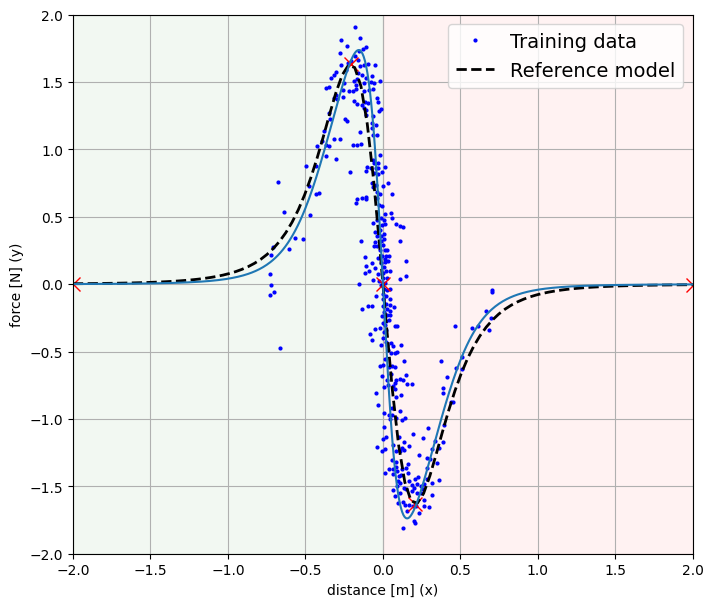

In [5]:
##
## set all synth_unkn_models.
##
#for model_name in synth_unkn_models_set[0].keys():
#    stree.set_unknown_model(model_name, *synth_unkn_models_set[0][model_name])

#
# show best stree.
#
if best_k_mse is None:
    #_, best_r2 = S.evaluate(stree.compute_output)
    raise RuntimeError('No model found.')
else:
    for unkn_label in best_unkn_models.keys():
        stree.set_unknown_model(unkn_label, best_unkn_models[unkn_label])

print("--- Best Syntax Tree ---")
print(f"K-MSE: {best_k_mse}")
print(f"R2:    {best_r2}")
S.plot(width=8, height=7)
xp = np.linspace(S.xl, S.xu, 500)
plt.plot(xp, stree.compute_output(xp));
plt.show()


--- Pull from A(x) ---


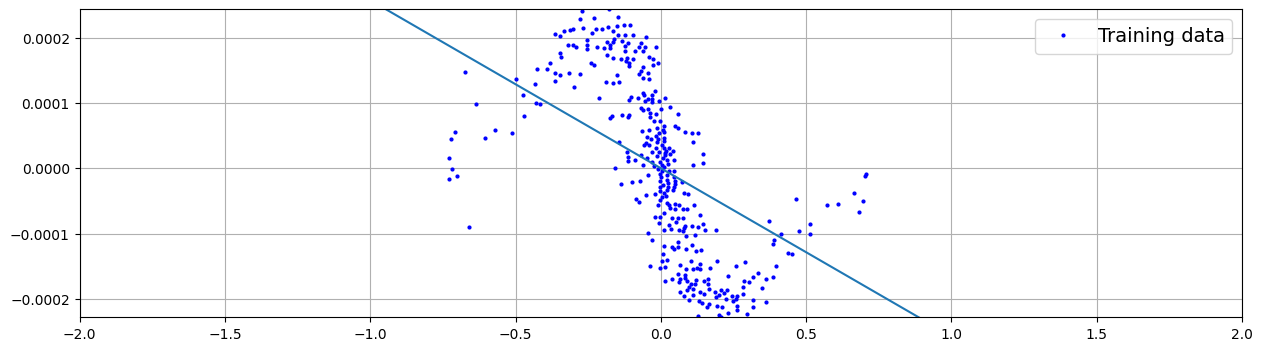

Model:
            5            3
-6.874e-12 x + 1.95e-12 x - 0.0002573 x
Coeffs Softmax:
[0.15703815 0.15703815 0.15703815 0.15703815 0.15703815 0.05777111
 0.15703815]

--- Pulled Eq/Ineq Constraints ---

--- Final Model ---
K-MSE: 12.939807939186005
R2:    -3.3421002908121062


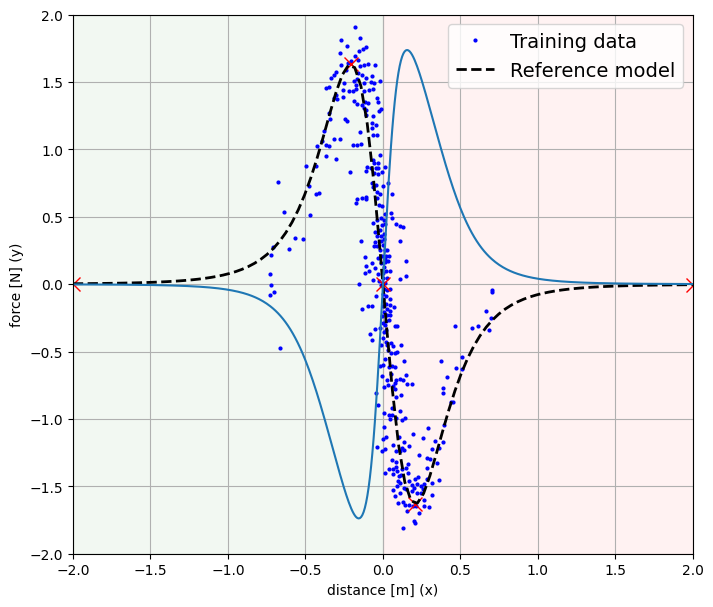



--- Pull from B(x) ---


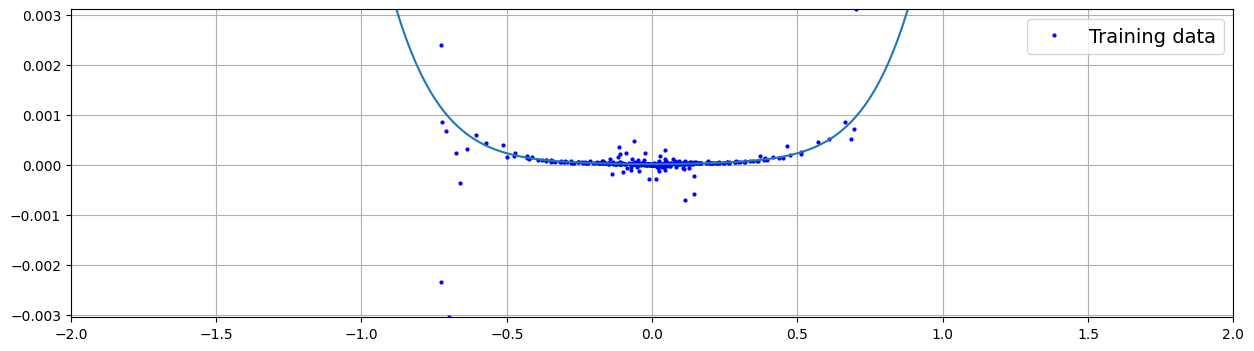

Model:
        6             4             2
0.0056 x + 0.0002497 x + 0.0004523 x + 1.186e-05
Coeffs Softmax:
[0.30714556 0.11299254 0.11814559 0.11299254 0.12249918 0.11299254
 0.11323205]

--- Pulled Eq/Ineq Constraints ---

--- Final Model ---
K-MSE: 0.19238291517003075
R2:    0.5966582875079387


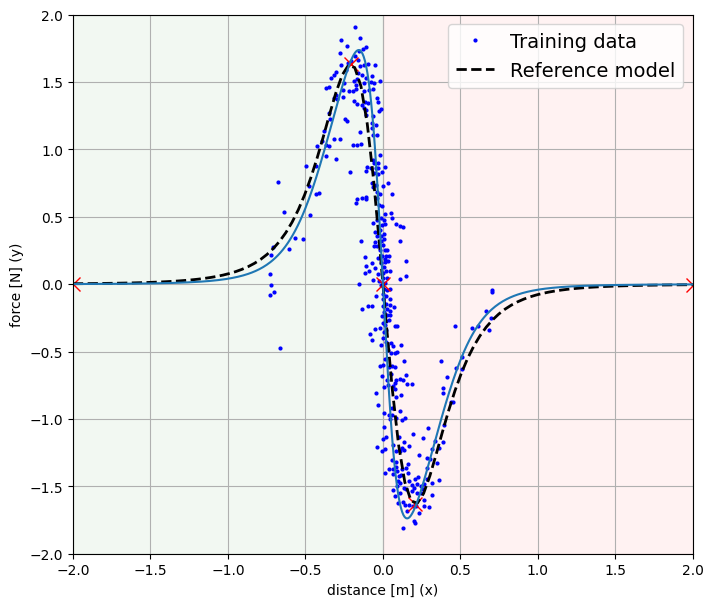



--- Pull from A(x) ---


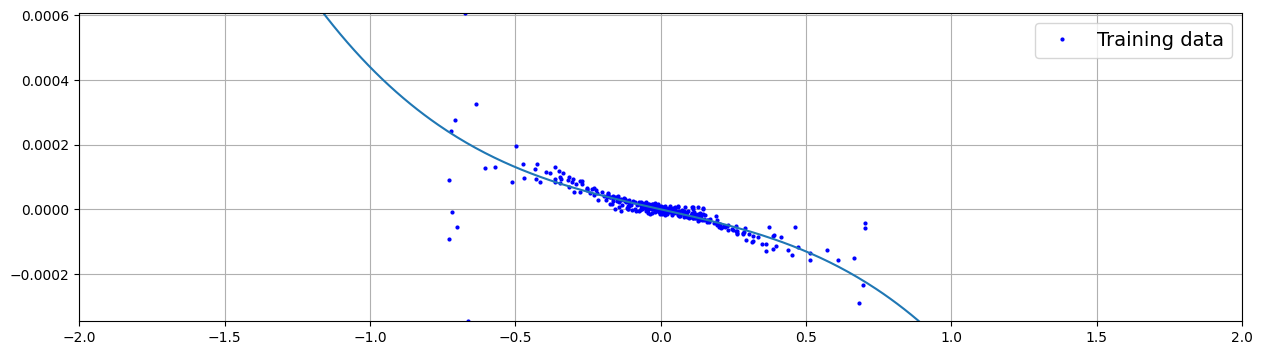

Model:
            5             3
-5.328e-10 x - 0.0002386 x - 0.000201 x
Coeffs Softmax:
[0.17245561 0.17245523 0.17245561 0.06344288 0.17245561 0.07427944
 0.17245561]

--- Pulled Eq/Ineq Constraints ---

--- Final Model ---
K-MSE: 0.06376615765767288
R2:    0.707060726775057


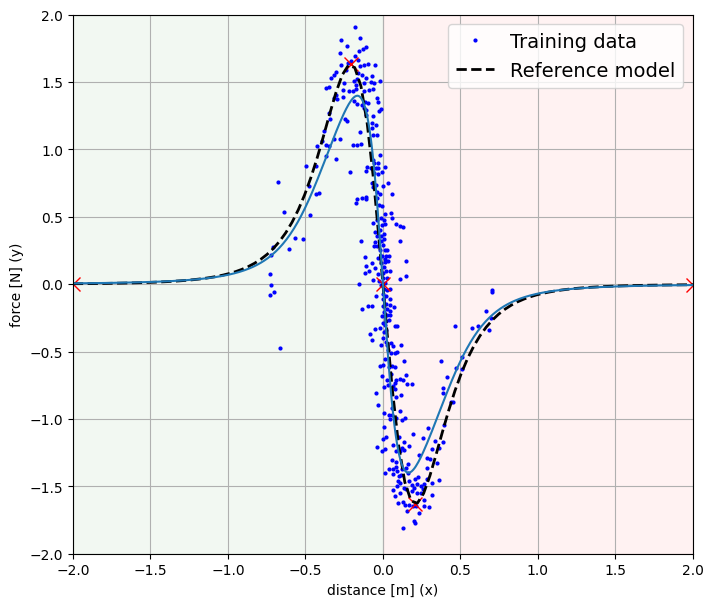



--- Pull from B(x) ---


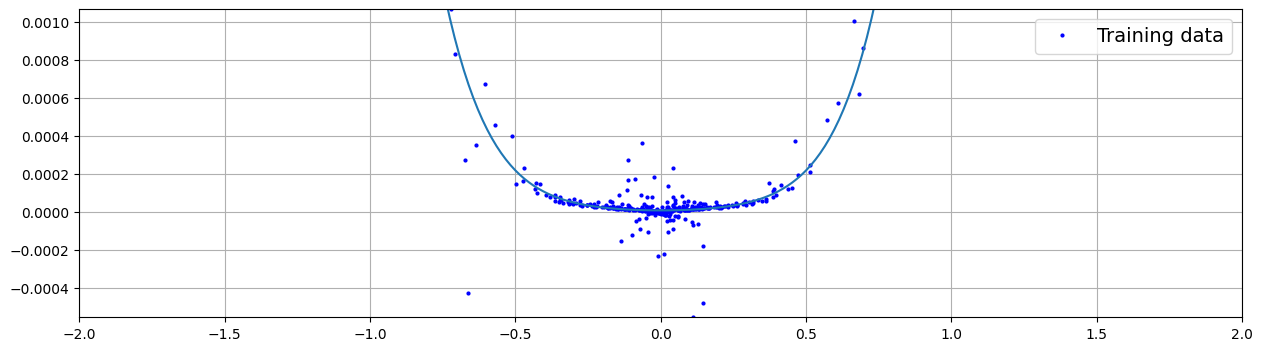

Model:
          6           4             2
0.003552 x + 0.00115 x + 0.0003319 x + 9.388e-06
Coeffs Softmax:
[0.2954307  0.10868288 0.15022107 0.10868288 0.11932908 0.10868288
 0.1089705 ]

--- Pulled Eq/Ineq Constraints ---

--- Final Model ---
K-MSE: 0.24713799623800461
R2:    0.5875121140894475


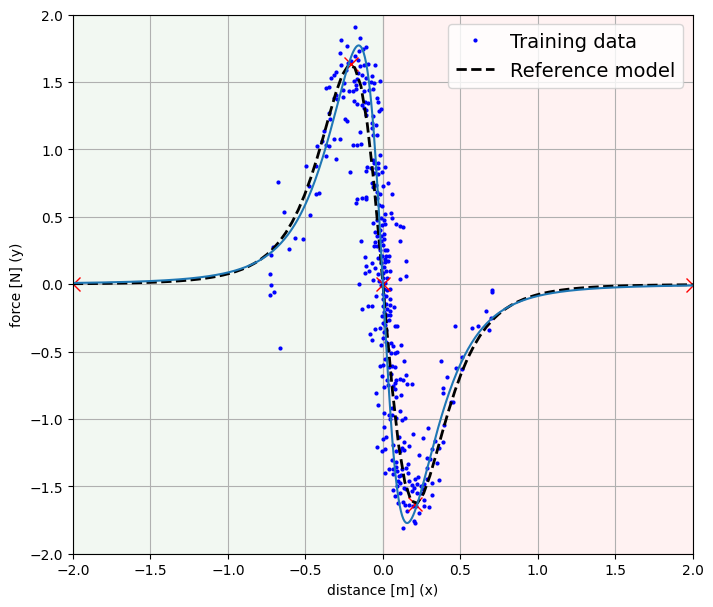

In [6]:
#
# show history (first Answer Set only).
#

constrmap = constraints.ConstraintMap()

for hist_entry in hist_set[0].entries:
    print(f"\n--- {hist_entry.msg} ---")
    
    if len(hist_entry.pulled_S.data) > 0:
        hist_entry.pulled_S.plot(width=15, height=4, plotref=False)
        xp = np.linspace(hist_entry.pulled_S.xl, hist_entry.pulled_S.xu, 500)
        plt.plot(xp, hist_entry.fit_model(xp));
        #plt.xlim(S.xl, S.xu)
        #plt.ylim(S.yl, S.yu)

        plt.show()
        import utils
        model, _ = utils.simplify_poly(hist_entry.fit_model, None)
        print(f"Model:\n{model}")
        print(f"Coeffs Softmax:\n{utils.coeffs_softmax(model.c)}")

    print("\n--- Pulled Eq/Ineq Constraints ---")
    for derivdeg in hist_entry.pulled_constrs.keys():
        for (dp, relopt) in hist_entry.pulled_constrs[derivdeg].eq_ineq:
            dp_x_str = "{:.8f}".format(dp.x)
            dp_y_str = "{:.8f}".format(dp.y)
            prime_sign = "'" * derivdeg
            constrmap.add(hist_entry.model_name + prime_sign, dp.x, dp.y, relopt)
            print(f"{hist_entry.model_name}{prime_sign}({dp_x_str}) {relopt.opt} {dp_y_str}")
    
    if len(hist_entry.violated_constrs) > 0:
        print("\n--- Violated Constraints ---")
        for (dp, relopt) in hist_entry.violated_constrs:
            dp_x_str = "{:.2f}".format(dp.x)
            dp_y_str = "{:.2f}".format(dp.y)
            print(f"m({dp_x_str}) {relopt.opt} {dp_y_str}")

    print("\n--- Final Model ---") 
    stree.set_unknown_model(hist_entry.model_name, hist_entry.fit_model)
    _, r2, k_mse = S.evaluate(stree.compute_output)
    print(f"K-MSE: {k_mse}")
    print(f"R2:    {r2}")
    
    S.plot(width=8, height=7)
    xp = np.linspace(S.xl, S.xu, 500)
    plt.plot(xp, stree.compute_output(xp));
    plt.show()

    print()